### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

#torch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import GraphConvolution
from torcheeg.models.gnn.dgcnn import normalize_A
# helper sctipts 
import utils as U
from training import TrainNN
from cka import CKACalculator, HookManager, cka_all_models
# tracking 
import wandb

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
seed = 42

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

### Load data

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict=bands)

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [4]:
def split_data(X, y, has_val_set=False, seed=42):
    
    if has_val_set:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)
        
        return (X_train, y_train, X_val, y_val, X_test, y_test)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

        return (X_train, y_train, X_test, y_test)


In [5]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [6]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 3
plot=True
new_models=False

## Train model

### Train 4 models and calculate CKA matrices for pairs of models

## Functions to get activations of a layer type and calculated adjacency matrix

In [7]:
mods = []
wandb.login()
def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}{i}.pth"
        print(f"Model {i}:")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            

train_models(DGCNN, TrainNN, num_models=3, prints=plot, new=new_models)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lili-raleva (braincells). Use `wandb login --relogin` to force relogin


Model 0:
Model 1:
Model 2:


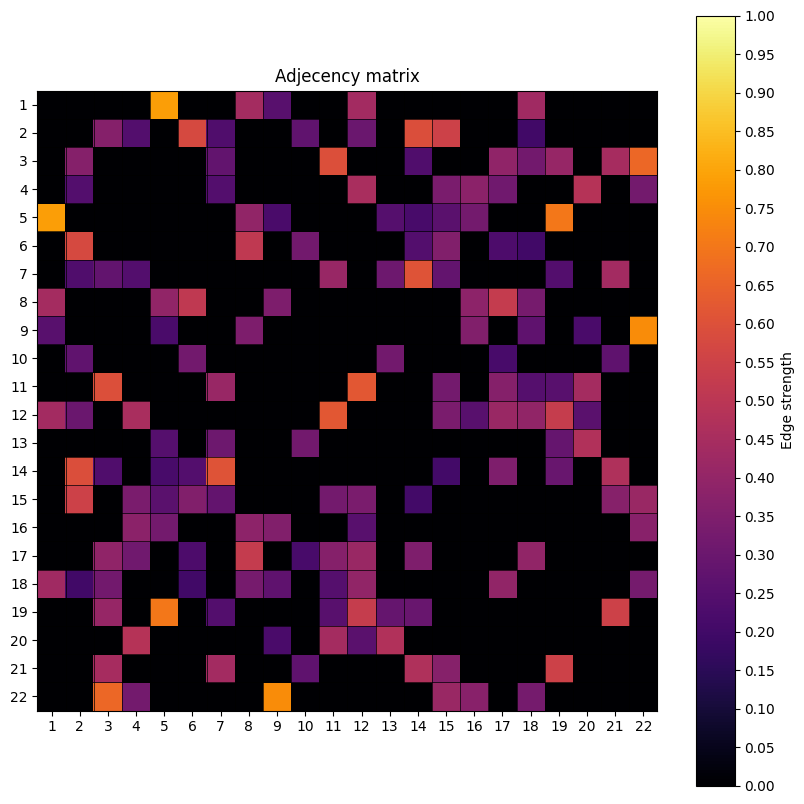

In [8]:

adj1 = U.get_adj_mat(mods[0][0])
adj2 = U.get_adj_mat(mods[1][0])
U.visualize_adj_mat(adj1)

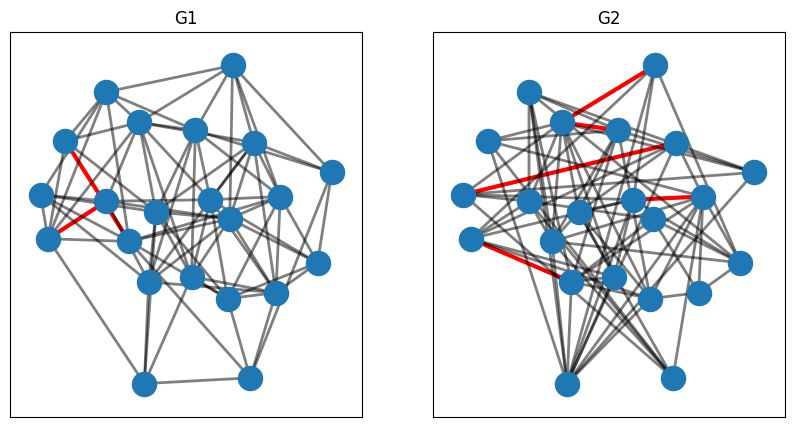

In [9]:
#Viz option 1
G1 = nx.from_numpy_array(adj1.numpy())
G2 = nx.from_numpy_array(adj2.numpy())

pos = nx.spring_layout(G1, seed=7)   # positions for all nodes - seed for reproducibility

elarge_1 = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] >= 0.7]
esmall_1 = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] < 0.7]

elarge_2 = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] >= 0.7]
esmall_2 = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] < 0.7]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(G1, pos)
nx.draw_networkx_edges(G1, pos, edgelist=elarge_1, width=3, edge_color= "red")
nx.draw_networkx_edges(G1, pos, edgelist=esmall_1, width=2, alpha=0.5, edge_color="black")
plt.title("G1")

plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(G2, pos)
nx.draw_networkx_edges(G2, pos, edgelist=elarge_2, width=3, edge_color= "red")
nx.draw_networkx_edges(G2, pos, edgelist=esmall_2, width=2, alpha=0.5, edge_color="black")
plt.title("G2")

plt.show()



Standard deviation: 0.0
Array max: 0.06848430633544922
Array min: 0.06848430633544922
Array mean: 0.06848430633544922


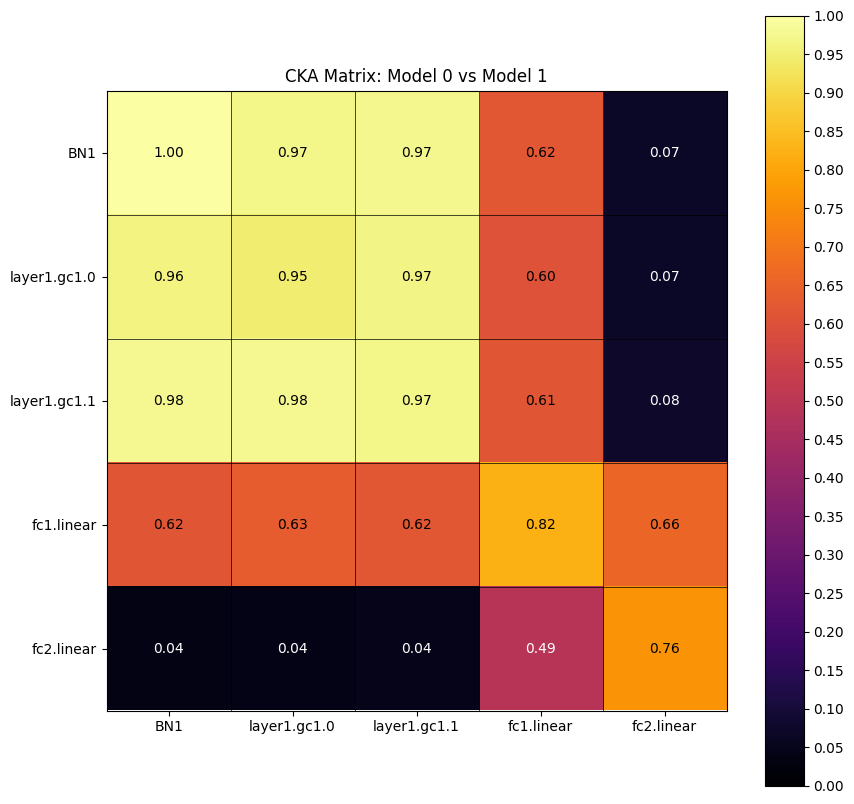

Standard deviation: 0.0
Array max: 0.040461812168359756
Array min: 0.040461812168359756
Array mean: 0.040461812168359756


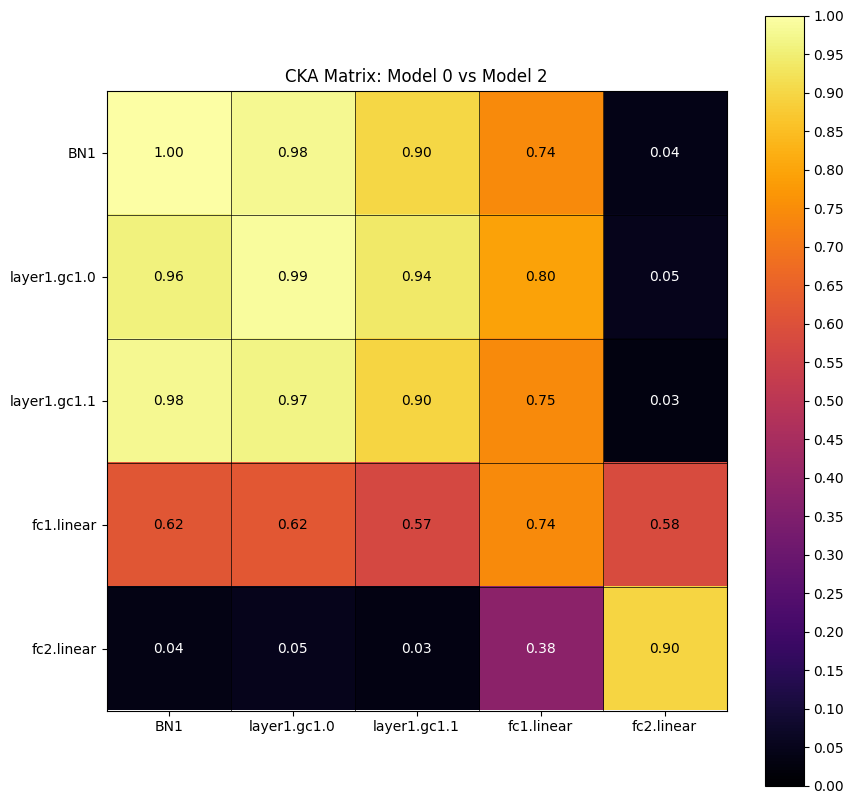

Standard deviation: 0.0
Array max: 0.040513306856155396
Array min: 0.040513306856155396
Array mean: 0.040513306856155396


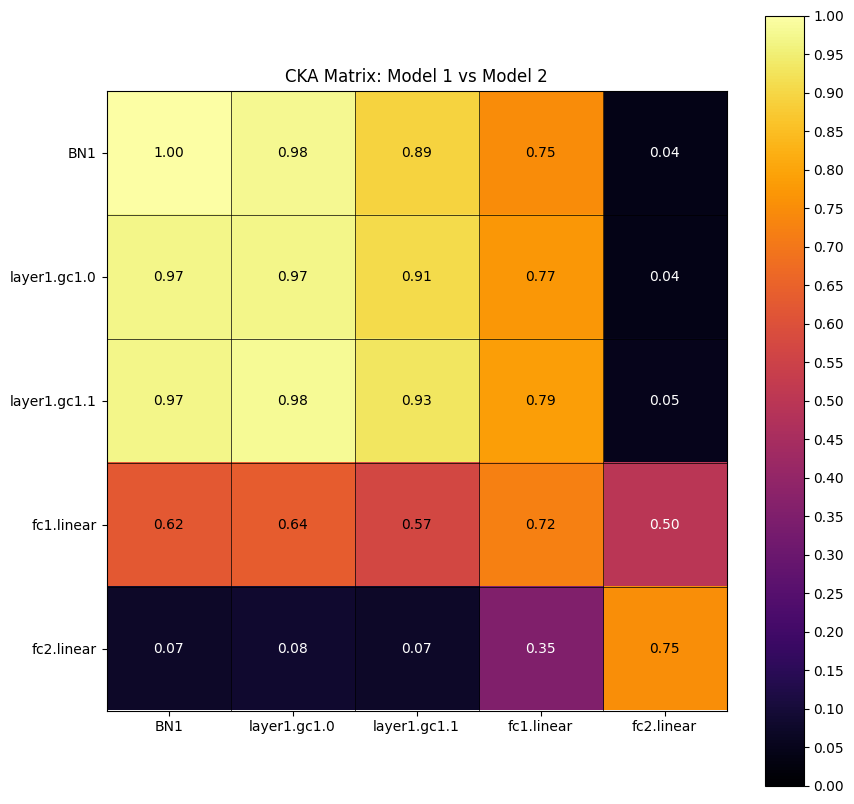

In [ ]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            U.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

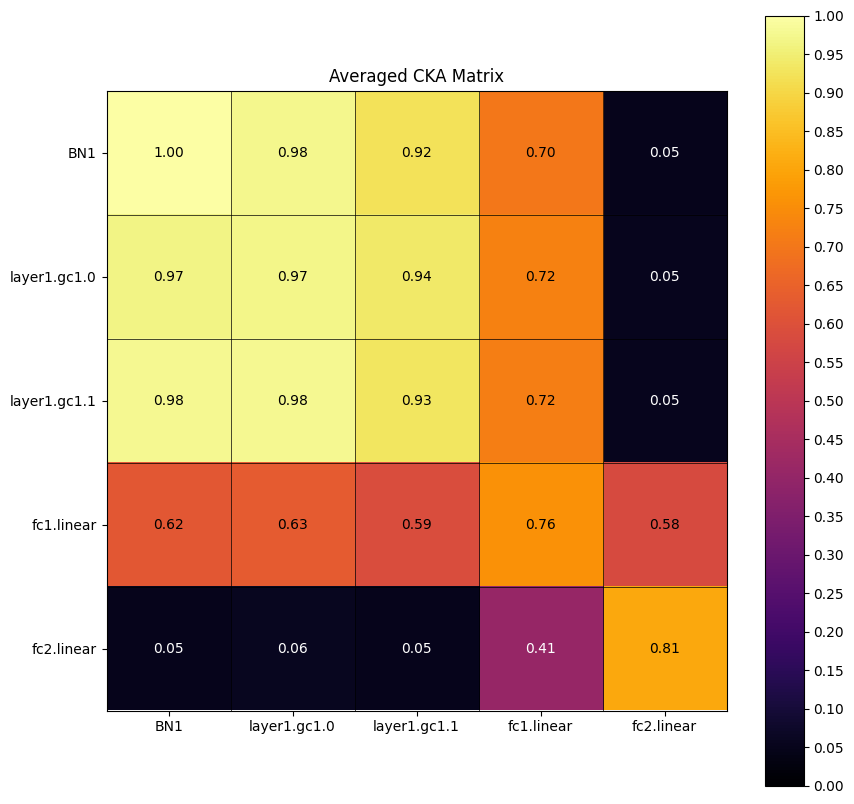

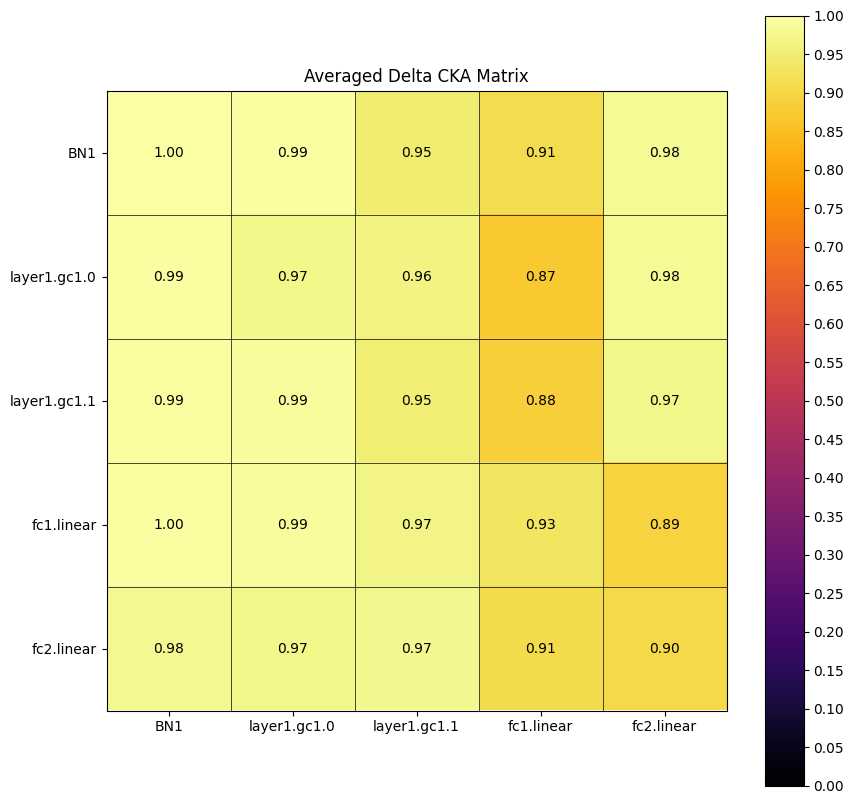

In [11]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  

U.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

U.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

In [12]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    